In [7]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop

import numpy as np
import random
import sys

# 準備

In [10]:
from tqdm import tqdm
import music21 as m21
import os

path = "../midi/元データ/MelodyTrackList.txt" #トラック指定のファイル

music_keys = ('C')
text = []

TrackList = []
with open(path) as f:
    TrackList = [s.strip().split("=") for s in f.readlines()] #パスとトラック番号を区切ってリスト化


# 音符・休符の文字列への変換

In [11]:
for x in tqdm(TrackList):
    track = m21.converter.parse(x[0])
    print(x[0]+str(len(track.parts)))
    piece = track.parts[int(x[1])-1]
    
    for trans_key in music_keys:
        k = piece.analyze('key')
        trans = trans_key
        
        i = m21.interval.Interval(k.tonic, m21.pitch.Pitch(trans))
        trans_piece = piece.transpose(i)
        for n in trans_piece.flat.notesAndRests:
            if not isinstance(n, m21.chord.Chord):
                text.append(str(n.name) + '_' + str(n.duration.quarterLength) + ' ')

  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

../midi/元データ\001.mid4


  3%|██▌                                                                                | 1/33 [00:00<00:18,  1.72it/s]

../midi/元データ\5ive_-_Dont_Wanna_Let_You_Go.mid16


  6%|█████                                                                              | 2/33 [00:01<00:21,  1.44it/s]

../midi/元データ\ainoaisatu.mid5


  9%|███████▌                                                                           | 3/33 [00:01<00:17,  1.71it/s]

../midi/元データ\airsulg.mid5


 12%|██████████                                                                         | 4/33 [00:02<00:14,  2.01it/s]

../midi/元データ\amairo.mid6


 18%|███████████████                                                                    | 6/33 [00:02<00:11,  2.35it/s]

../midi/元データ\amaririsu.mid7
../midi/元データ\amepato.mid6


 21%|█████████████████▌                                                                 | 7/33 [00:03<00:10,  2.47it/s]

../midi/元データ\annie_laurie.mid5


 27%|██████████████████████▋                                                            | 9/33 [00:03<00:07,  3.17it/s]

../midi/元データ\aogeba.mid6
../midi/元データ\asibue.mid5


 30%|████████████████████████▊                                                         | 10/33 [00:04<00:08,  2.68it/s]

../midi/元データ\avemaria.mid4


 36%|█████████████████████████████▊                                                    | 12/33 [00:04<00:07,  2.81it/s]

../midi/元データ\carousel.mid6
../midi/元データ\clapolka.mid5


 42%|██████████████████████████████████▊                                               | 14/33 [00:06<00:09,  1.91it/s]

../midi/元データ\d-akaikutu.mid1


 45%|█████████████████████████████████████▎                                            | 15/33 [00:06<00:08,  2.16it/s]

../midi/元データ\d-arupusu.mid5
../midi/元データ\d-chatu.mid4


 52%|██████████████████████████████████████████▏                                       | 17/33 [00:07<00:06,  2.32it/s]

../midi/元データ\d-choucho.mid3


 55%|████████████████████████████████████████████▋                                     | 18/33 [00:08<00:05,  2.66it/s]

../midi/元データ\d-fujisan.mid4
../midi/元データ\d-fuyugesiki.mid4


 61%|█████████████████████████████████████████████████▋                                | 20/33 [00:08<00:03,  3.92it/s]

../midi/元データ\d-genkotu.mid5


 64%|████████████████████████████████████████████████████▏                             | 21/33 [00:08<00:03,  3.64it/s]

../midi/元データ\d-gonbe.mid5
../midi/元データ\d-hamabe.mid4


 70%|█████████████████████████████████████████████████████████▏                        | 23/33 [00:08<00:02,  4.71it/s]

../midi/元データ\d-hamatidori.mid2
../midi/元データ\d-haruga.mid5


 76%|██████████████████████████████████████████████████████████████                    | 25/33 [00:09<00:01,  5.02it/s]

../midi/元データ\d-harun.mid3
../midi/元データ\d-harunohino.mid3


 82%|███████████████████████████████████████████████████████████████████               | 27/33 [00:09<00:00,  6.07it/s]

../midi/元データ\d-haruyo.mid2
../midi/元データ\d-hiraita.mid3


 88%|████████████████████████████████████████████████████████████████████████          | 29/33 [00:09<00:00,  5.58it/s]

../midi/元データ\d-hotaru.mid4
../midi/元データ\d-itigatu.mid3


 91%|██████████████████████████████████████████████████████████████████████████▌       | 30/33 [00:10<00:00,  6.28it/s]

../midi/元データ\d-itiniti.mid2
../midi/元データ\d-jinguru.mid5


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.10it/s]

../midi/元データ\d-kaeru.mid7


# 辞書の作成

In [12]:
print("LSTM start")
chars = text
count = 0
char_indices = {} #辞書
indices_char = {} #逆引き辞書

for word in chars:
    if not word in char_indices:
        char_indices[word] = count #key=word, value=count
        count += 1
        #print(count, word)

#逆引き辞書の作成
indices_char = dict([(value, key) for (key, value) in char_indices.items()])


LSTM start


# 文章の作成

In [13]:
maxlen = 16
step = 1
sentences = []
next_chars = []
for i in range(0, len(text)-maxlen, step): #初項0, 末項len..., 公差step
    sentences.append(text[i:i+maxlen])
    next_chars.append(text[i+maxlen])

print("nb sequences:", len(sentences))

nb sequences: 6822


# One-Hotベクトル化

In [14]:
print("Vectorization...")
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1 #sentence番号, sentence内のindex, 辞書での文字の番号
    y[i, char_indices[next_chars[i]]] = 1 #正解データ


Vectorization...


# モデルの作成

In [15]:
from keras import regularizers
epochs = 100 #500
print("Build model...")
model = Sequential()
#model.add(Dropout(0.2))
model.add(LSTM(30, input_shape=(maxlen, len(chars))))
#model.add(Dropout(0.5))
model.add(Dense(len(chars), activation='softmax'))
#model.add(Dense(len(chars), activation='softmax' ,kernel_regularizer=regularizers.l2(0.002)))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
stack = model.fit(x,y,batch_size=256,epochs=epochs, validation_split=0.2)
model.save('melo.h5')

Build model...

Train on 5457 samples, validate on 1365 samples
Epoch 1/100
5457/5457 [==============================] - 7s 1ms/step - loss: 5.0837 - accuracy: 0.0709 - val_loss: 4.4818 - val_accuracy: 0.0227
Epoch 2/100
5457/5457 [==============================] - 5s 941us/step - loss: 4.0483 - accuracy: 0.0828 - val_loss: 4.2871 - val_accuracy: 0.0520
Epoch 3/100
5457/5457 [==============================] - 5s 929us/step - loss: 3.8265 - accuracy: 0.1021 - val_loss: 4.2130 - val_accuracy: 0.0374
Epoch 4/100
5457/5457 [==============================] - 5s 936us/step - loss: 3.7247 - accuracy: 0.1145 - val_loss: 4.0693 - val_accuracy: 0.0579
Epoch 5/100
5457/5457 [==============================] - 5s 938us/step - loss: 3.6912 - accuracy: 0.1329 - val_loss: 3.9952 - val_accuracy: 0.0689
Epoch 6/100
5457/5457 [==============================] - 5s 938us/step - loss: 3.4446 - accuracy: 0.1492 - val_loss: 3.9163 - val_accuracy: 0.1385
Epoch 7/100
5457/5457 [==============================] -

5457/5457 [==============================] - 5s 900us/step - loss: 0.5166 - accuracy: 0.8763 - val_loss: 6.0735 - val_accuracy: 0.1502
Epoch 55/100
5457/5457 [==============================] - 5s 910us/step - loss: 0.5104 - accuracy: 0.8772 - val_loss: 5.9547 - val_accuracy: 0.1575
Epoch 56/100
5457/5457 [==============================] - 5s 910us/step - loss: 0.4895 - accuracy: 0.8844 - val_loss: 6.0809 - val_accuracy: 0.1612
Epoch 57/100
5457/5457 [==============================] - 5s 905us/step - loss: 0.4594 - accuracy: 0.8871 - val_loss: 6.2770 - val_accuracy: 0.1538
Epoch 58/100
5457/5457 [==============================] - 5s 908us/step - loss: 0.4540 - accuracy: 0.8900 - val_loss: 6.0560 - val_accuracy: 0.1641
Epoch 59/100
5457/5457 [==============================] - 5s 910us/step - loss: 0.4257 - accuracy: 0.9020 - val_loss: 6.3810 - val_accuracy: 0.1685
Epoch 60/100
5457/5457 [==============================] - 5s 902us/step - loss: 0.4206 - accuracy: 0.9031 - val_loss: 6.4622 

# 学習曲線の描画

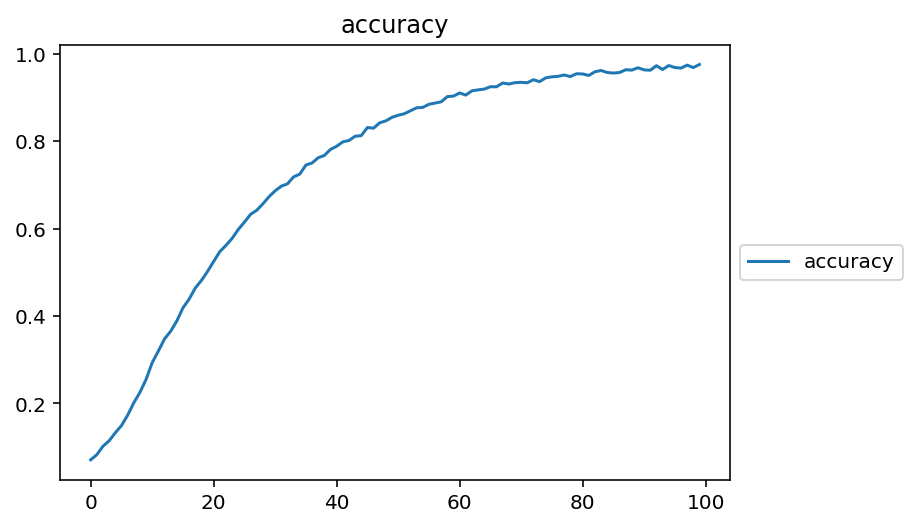

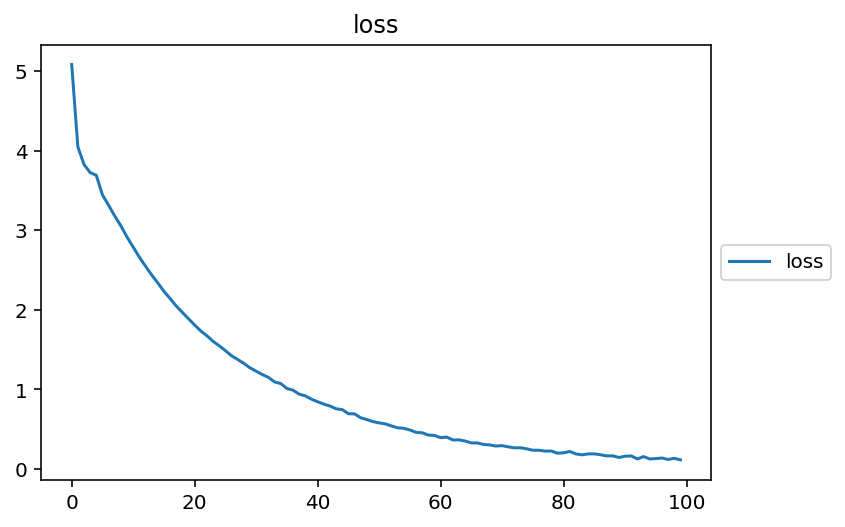

In [16]:
import matplotlib.pyplot as plt

x = range(epochs)

plt.plot(x, stack.history['accuracy'], label="accuracy")
#plt.plot(x, stack.history['val_accuracy'], label="val_accuracy", color="orange")
plt.title("accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


plt.plot(x, stack.history['loss'], label="loss")
#plt.plot(x, stack.history['val_loss'], label="val_loss", color="orange")
plt.title("loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# 主旋律の生成

In [20]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds) #softmax関数の計算
    probas = np.random.multinomial(1, preds, 1) 
    #http://www.gentosha-academy.com/serial/okamoto-4/ にmultinomialの説明あり
    #今回は1からkがpreds=[p1,p2,...,pk]という度数分布に従っているとき、
    #1回(var1)試行を行ったときの度数分布が1サンプル(var3)得られる
    return np.argmax(probas) #1になっている要素番号を返す


In [21]:
def make_melody(length=200):
    #適当にスタートの文を選ぶ
    start_index = random.randint(0, len(text)-maxlen-1)
    
    for diversity in [0.2]:
        generated = ''
        sentence = text[start_index:start_index+maxlen] #ここでユーザのメロディを与えると続きを生成
        generated += ''.join(sentence) #sentence(list)の各要素を結合してgeneratedに追加
        print(sentence)
        
        for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1
            
            preds = model.predict(x_pred, verbose=0)[0] #verbose:詳細 0で詳細情報を表示しない
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            
            generated += next_char
            sentence = sentence[1:]
            sentence.append(next_char)
            
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
    return generated

#model = load_model('melo.h5')
melo_sentence = make_melody(30)
print(melo_sentence)

['A_1/3 ', 'rest_1/6 ', 'A_0.5 ', 'G_1.0 ', 'rest_0.5 ', 'G_0.5 ', 'C_0.5 ', 'D_0.5 ', 'E_2/3 ', 'rest_1/12 ', 'E_0.25 ', 'E_1/3 ', 'rest_1/6 ', 'E_0.5 ', 'G_2/3 ', 'rest_1/12 ']
G_0.25 G_0.5 E_2/3 D_0.5 C_0.5 D_1.0 rest_0.5 G_1/3 rest_1/6 G_0.5 E_0.5 D_2/3 rest_1/12 D_1/3 C_0.5 A_0.5 G_2/3 C_2/3 D_0.75 E_0.25 C_1.5 rest_1.0 G_0.5 C_0.5 D_0.5 E_0.75 E_0.25 E_0.5 E_0.5 G_2/3 
A_1/3 rest_1/6 A_0.5 G_1.0 rest_0.5 G_0.5 C_0.5 D_0.5 E_2/3 rest_1/12 E_0.25 E_1/3 rest_1/6 E_0.5 G_2/3 rest_1/12 G_0.25 G_0.5 E_2/3 D_0.5 C_0.5 D_1.0 rest_0.5 G_1/3 rest_1/6 G_0.5 E_0.5 D_2/3 rest_1/12 D_1/3 C_0.5 A_0.5 G_2/3 C_2/3 D_0.75 E_0.25 C_1.5 rest_1.0 G_0.5 C_0.5 D_0.5 E_0.75 E_0.25 E_0.5 E_0.5 G_2/3 


# 出力

In [23]:
#メロディをmidiに変換
meas = m21.stream.Stream()
meas.append(m21.meter.TimeSignature('4/4'))
melo = melo_sentence.split()
for m in melo:
    pitch, dist = m.split('_')
    tmp = dist.split('/')
    if len(tmp) == 2:
        fdist = float(tmp[0])/float(tmp[1])
    else:
        fdist = float(tmp[0])
    
    if pitch == "rest":
        n = m21.note.Rest(quarterLength = fdist)
    else:
        n = m21.note.Note(pitch, quarterLength = fdist)
    
    meas.append(n)

meas.makeMeasures(inPlace=True)
meas.show("midi", addEndTimes=True)
meas.write("midi", fp="./melo.mid")

'./melo.mid'